# modifications:
1) weight initialization with RandomNormal: you can see it in the beginning of the definition of the functions "define_discriminator" and "define_generator" and within the generation of each layer: "kernel_initializer=init" instead of kernel_initializer="orthogonal".

2) add dropout after each layer.

3) add noise to labels. to do.

4) study best metrics for labels. to do.

5) try hybrids: discriminator taken from a kind of GAN and generator from another kind. to do.

6) make parameters like latent_space_dim , the dimension of the filter embedded in the generator in the firts layer, the batch size, etc dependent on the number of images and attributes used.

# Note:

- this is the auxiliary gan taken from the book, adapted to the celebA dataset.

- The problem is that the number of filters is too big so there's not enough memory to do the math: if you add the commented hidden layers of the discriminator it raises an error.

- the discriminator has a low loss from the beginning, it changes adding the dropout after the flattening layer.


In [1]:
import numpy as np
from numpy.random import randn
from numpy.random import randint
import os
import cv2
import pandas as pd
import gzip
from tensorflow.keras import backend as K
import tensorflow as tf 
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.initializers import RandomNormal

#epsilon set according to BIGGAN https://arxiv.org/pdf/1809.11096.pdf

def _l2normalizer(v, epsilon=1e-4):
    return v / (K.sum(v**2)**0.5 + epsilon)


def power_iteration(W, u, rounds=1):
    '''
    Accroding the paper, we only need to do power iteration one time.
    '''
    _u = u

    for i in range(rounds):
        _v = _l2normalizer(K.dot(_u, W))
        _u = _l2normalizer(K.dot(_v, K.transpose(W)))

    W_sn = K.sum(K.dot(_u, W) * _v)
    return W_sn, _u, _v

"""
Convolution 2D with spectral normalization
"""
class SNConv2D(Conv2D):
    def __init__(self, filters, spectral_normalization=True, **kwargs):
        self.spectral_normalization = spectral_normalization
        super(SNConv2D, self).__init__(filters, **kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.

        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2D, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-1], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):

        outputs = K.conv2d(inputs,
                           self.compute_spectral_normal(training=training),
                           strides=self.strides, padding=self.padding,
                           data_format=self.data_format,
                           dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2D, self).compute_output_shape(input_shape)

"""
Transposed Convolution 2D with spectral normalization
"""
class SNConv2DTranspose(Conv2DTranspose):
    def __init__(self, spectral_normalization=True, **kwargs):
        self.spectral_normalization = spectral_normalization
        super(SNConv2DTranspose, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2DTranspose, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-2], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        out_pad_h = out_pad_w = None

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_output_length(
            height, kernel_h, self.padding, stride=stride_h)
        out_width = conv_utils.deconv_output_length(
            width, kernel_w, self.padding, stride=stride_w)
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        outputs = K.conv2d_transpose(
            inputs,
            self.compute_spectral_normal(training=training),
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format
        )

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2DTranspose, self).compute_output_shape(input_shape)

    
# define the standalone discriminator model
# A best practice involves using an embedding
# layer followed by a fully connected layer with a linear activation that scales the embedding to
# the size of the image before concatenating it in the model as an additional channel or feature
# map. A version of this recommendation was described in the 2015 paper titled Deep Generative
# Image Models using a Laplacian Pyramid of Adversarial Networks.

    
def define_discriminator(in_shape=(64,64,3), n_classes=3): # HERE
    
    # kernel initializer:
    init = RandomNormal(stddev=0.02)
    
    ##
    
    # input layer:
    in_image = Input(shape=in_shape) ##

    # downsample to 32x32
    fe = SNConv2D(64, kernel_size=4, strides=(2,2), padding='same', kernel_initializer=init, spectral_normalization=True)(in_image) ##in_image
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = SNConv2D(128, kernel_size=4, padding='same', kernel_initializer=init, spectral_normalization=True)(in_image) ##in_image
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 16x16
    fe = SNConv2D(256, kernel_size=4, strides=(2,2), padding='same', kernel_initializer=init, spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    
    # these hidden layers create problems of computation:
    # normal
    #fe = SNConv2D(512, kernel_size=4, padding='same', kernel_initializer=init, spectral_normalization=True)(fe)
    #fe = LeakyReLU(alpha=0.2)(fe)
    #fe = Dropout(0.5)(fe)
    # downsample to 8x8
    #fe = SNConv2D(1024, kernel_size=4, strides=(2,2), padding='same', kernel_initializer=init, spectral_normalization=True)(fe)
    #fe = LeakyReLU(alpha=0.2)(fe)
    #fe = Dropout(0.5)(fe)
    # normal
    #fe = SNConv2D(2048, kernel_size=4, padding='same', kernel_initializer=init, spectral_normalization=True)(fe)
    #fe = LeakyReLU(alpha=0.2)(fe)
    #fe = Dropout(0.5)(fe)
    
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    #fe = Dropout(0.5)(fe)
    
    # output about fake/real image:
    out1 = Dense(1, activation='sigmoid')(fe)
    # output about attributes:
    out2 = Dense(n_classes, activation="sigmoid")(fe) ##
    
    # define model
    model = Model([in_image], [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=["binary_crossentropy", "binary_crossentropy"], optimizer=opt, metrics=['accuracy']) ##
    return model



# define the standalone generator model
def define_generator(latent_dim, n_classes=3): # HERE,  TO TEST WITH SAME NUMBER OF ATTR INSTEAD 2
    # weights initialization:
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(3,)) # HERE, "3" is becaue of the third dimension of each image.
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label) # TO TEST WITH SAME NUMBER OF ATTR INSTEAD OF 50 (TEST ALSO 32)
    # linear multiplication
    n_nodes = 4 * 4
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((4, 4, 3))(li) # HERE,  "3" is becaue of the third dimension of each image.
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 4x4 image
    n_nodes = 128 * 4 * 4
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 8x8
    gen = SNConv2DTranspose(filters=128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer=init, spectral_normalization=True)(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 16x16
    gen = SNConv2DTranspose(filters=64, kernel_size=4, strides=(2,2), padding='same', kernel_initializer=init, spectral_normalization=True)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 32x32
    gen = SNConv2DTranspose(filters=32, kernel_size=4, strides=(2,2), padding='same', kernel_initializer=init, spectral_normalization=True)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 64x64
    gen = SNConv2DTranspose(filters=1, kernel_size=4, strides=(2,2), padding='same', kernel_initializer=init, spectral_normalization=True)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = SNConv2D(3, kernel_size=4, activation='tanh', padding='same', kernel_initializer=init, spectral_normalization=True)(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=["binary_crossentropy", "binary_crossentropy"], optimizer=opt) ##
    return model


In [2]:
def get_attributes(filename):
    attributes = pd.read_csv(filename)
    #return np.array(attributes.drop('image_id', axis=1))[:how_many]
    '''
    return np.array(attributes[['No_Beard', 'Young', 'Attractive', 'Mouth_Slightly_Open', 'Smiling', 
                                'Wearing_Lipstick', 'High_Cheekbones', 'Male', 'Heavy_Makeup', 
                                'Wavy_Hair',
                               'Oval_Face',
                               'Pointy_Nose',
                               'Arched_Eyebrows']])[:how_many]
    '''
    return np.array(attributes[['Blond_Hair', 'Male', 'Smiling']])[:how_many]
    

def load_dataset(dataset):
    X = []
    for i, myid in enumerate(dataset):
        image = load_img(directory + "/" + myid, target_size=img_shape[:2])
        image = (img_to_array(image) - 127.5) / 127.5 # from [0, 255] to [-1, 1]
        image = image[25:153, 45:173]
        image = cv2.resize(src=image, dsize=(64, 64))
        X.append(image)
    X = np.array(X)
    attributes = get_attributes(attr_file)
    attributes[attributes == -1] = 0 # replace label -1 to 0 for simplicity in generating random values later on
    return(X, attributes)

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    #print('X.shape: ', X.shape, 'labels.shape: ', labels.shape, 'y.shape: ', y.shape)
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=2): # two calsses: -1 and 1
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim) # (64, 100)
    # generate labels
    labels = np.random.randint(n_classes, size=(n_samples, 3)) # HERE (n_samples, 40)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    #print('z_input: ', z_input.shape, 'labels_input: ', labels_input.shape)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = np.zeros((n_samples, 1))
    #print('images: ', images.shape, 'labels_input: ', labels_input.shape, 'y: ', y.shape)
    return [images, labels_input], y

In [3]:
# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

In [4]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=30, n_batch=32):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected ✬real✬ samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            #print('X_real: ',X_real.shape,'labels_real: ' ,labels_real.shape, 'y_real: ',y_real.shape)
            # update discriminator model weights
            d_metrics1 = d_model.train_on_batch(X_real, [y_real, labels_real])##
            #d_loss1, _ = d_model.train_on_batch([X_real,labels_real], y_real)##
            # use this command: d_model.metrics_names to see what returns "d_model.train_on_batch"
            d_loss1 = d_metrics1[0]
            # generate ✬fake✬ examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_metrics2 = d_model.train_on_batch(X_fake, [y_fake,labels])
            d_loss2 = d_metrics2[0]
            # prepare points in latent space as input for the generator
            [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator✬s error
            #_,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
            g_metrics = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
            g_loss = g_metrics[0]
            
        # summarize loss on this batch
        print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # save the generator model
        g_model.save('aux_aux_gan/cgan_generator' +str(i+j)+'.h5')
        
        # blonde
        print("Blonde")
        model = load_model('aux_aux_gan/cgan_generator' +str(i+j)+'.h5',
                           custom_objects={'SNConv2DTranspose':SNConv2DTranspose, 'SNConv2D': SNConv2D})
        latent_points, labels = generate_latent_points(100, 100)
        # specify labels
        labels = np.zeros((100,3)) # HERE (100, 40)
        labels[:,0] = 1
        # generate images
        X = g_model.predict([latent_points, labels])
        # scale from [-1,1] to [0,1]
        X = (X + 1) / 2.0
        save_plot(X, 5)
        

In [7]:
directory = 'img_align_celeba/img_align_celeba'
attr_file = 'list_attr_celeba.csv'
how_many = 50000
celeba_img = np.sort(os.listdir(directory))
dataset = celeba_img[:how_many]
img_shape = (178, 218, 3)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
#dataset = load_mnist('fash', kind='train')
dataset = load_dataset(dataset)

>1, 1562/1562, d1=0.217, d2=0.637 g=6.496
Blonde


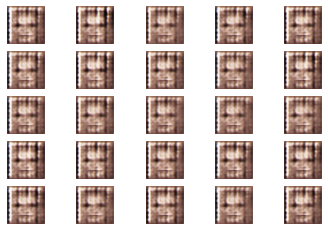

>2, 1562/1562, d1=0.475, d2=0.426 g=9.759
Blonde


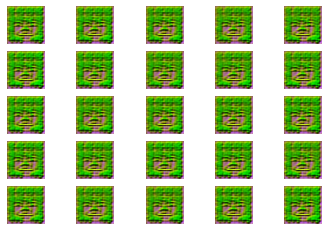

>3, 1562/1562, d1=0.197, d2=0.362 g=4.979
Blonde


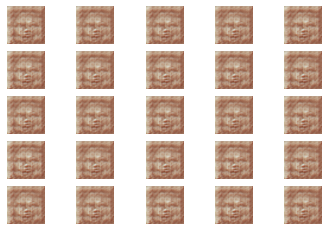

>4, 1562/1562, d1=0.398, d2=0.100 g=6.297
Blonde


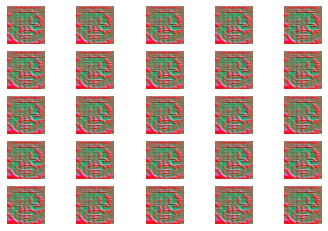

>5, 1562/1562, d1=0.483, d2=0.250 g=4.764
Blonde


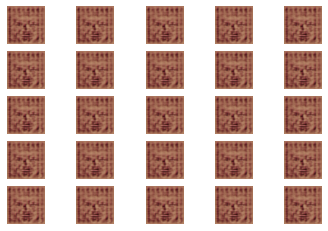

>6, 1562/1562, d1=0.903, d2=0.132 g=4.674
Blonde


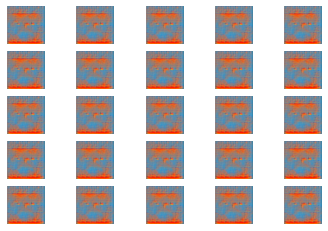

>7, 1562/1562, d1=0.229, d2=0.332 g=8.182
Blonde


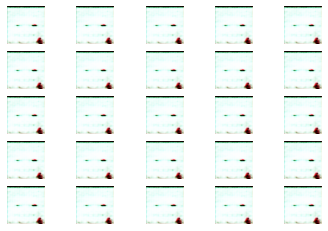

>8, 1562/1562, d1=0.472, d2=0.198 g=4.878
Blonde


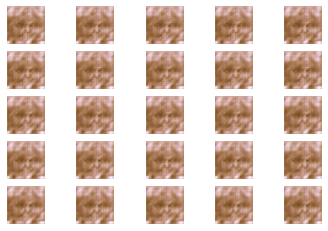

>9, 1562/1562, d1=0.332, d2=0.084 g=6.273
Blonde


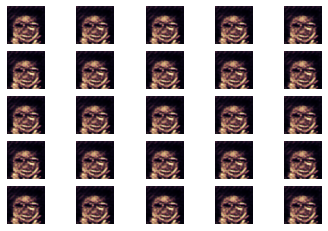

>10, 1562/1562, d1=0.123, d2=0.037 g=6.688
Blonde


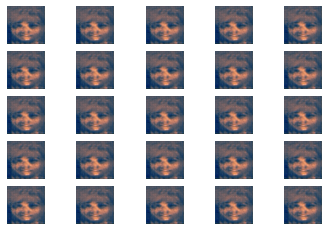

>11, 1562/1562, d1=0.118, d2=0.086 g=6.042
Blonde


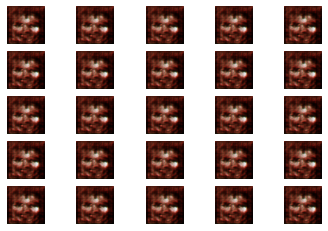

>12, 1562/1562, d1=0.217, d2=0.100 g=5.286
Blonde


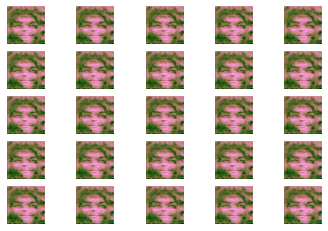

>13, 1562/1562, d1=0.110, d2=0.058 g=7.309
Blonde


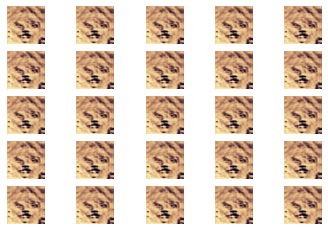

>14, 1562/1562, d1=0.208, d2=0.100 g=6.832
Blonde


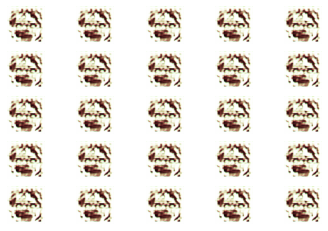

>15, 1562/1562, d1=0.343, d2=0.160 g=5.210
Blonde


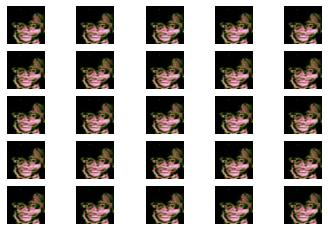

>16, 1562/1562, d1=0.092, d2=0.112 g=6.042
Blonde


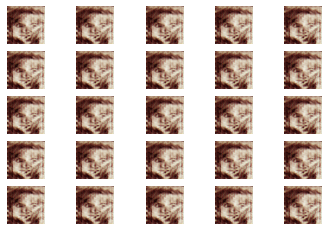

KeyboardInterrupt: 

In [8]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim);

In [ ]:
model = load_model('aux_aux_gan/cgan_generator1590.h5',
                           custom_objects={'SNConv2DTranspose':SNConv2DTranspose, 'SNConv2D': SNConv2D})
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = np.zeros((100,3)) # HERE (100, 40)
labels[:,2] = 1
# generate images
X = g_model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
save_plot(X, 5)